# Dataset: Wheel Speed

In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# Plotting the dataset

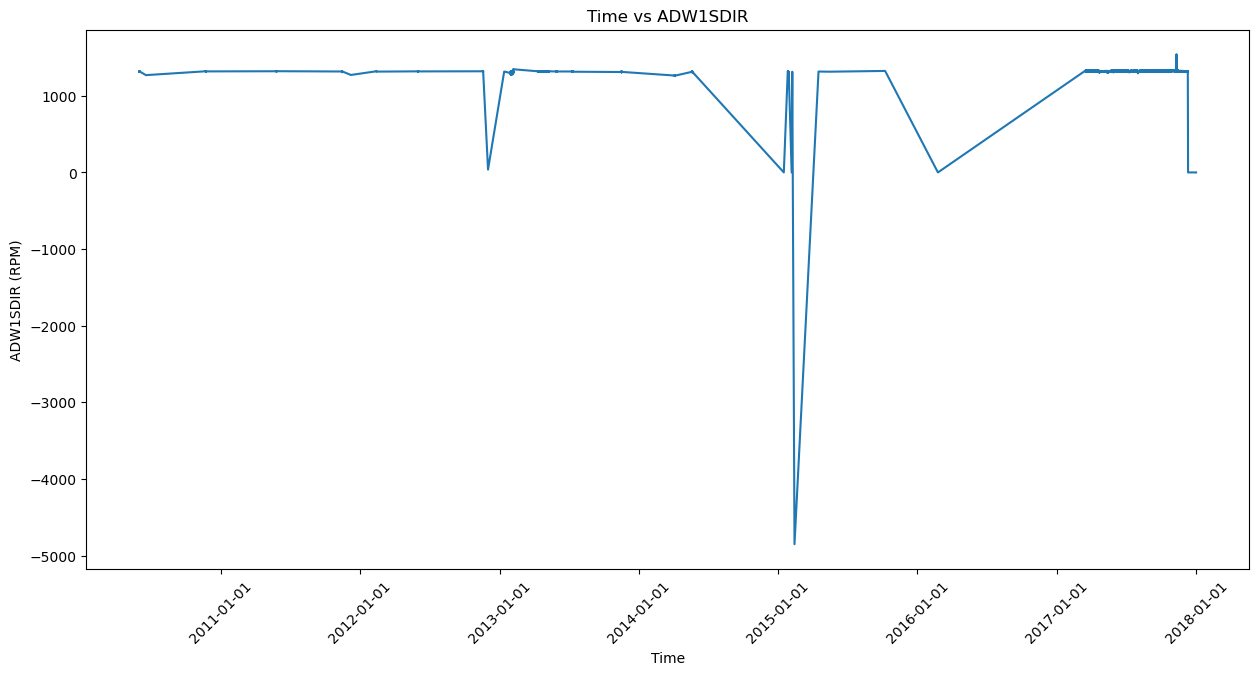

In [2]:
# load the data with 'time' parsed as datetime and set as index
wheelSpeedData = pd.read_csv(r"C:\Users\Sayantan Datta\Desktop\Uni\Unsupervised ML\Final Project\Final Project Dataset\Wheel1SpeedDirection_resampled.csv", parse_dates=['time'])
wheelSpeedData.set_index('time', inplace=True)

# visualize the time series data
plt.figure(figsize=(15, 7))
plt.plot(wheelSpeedData.index, wheelSpeedData['ADW1SDIR (RPM)'])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('ADW1SDIR (RPM)')
plt.title('Time vs ADW1SDIR')
plt.show()


# Preprocessing the data for our model

In [3]:
# prepare the data for model input
data = wheelSpeedData['ADW1SDIR (RPM)'].values
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data.reshape(-1, 1)).flatten()

def create_sequences(data, timestamps, time_steps=1):
    xs, ys, ts = [], [], []
    for i in range(len(data) - time_steps):
        xs.append(data[i:(i + time_steps)])
        ys.append(data[i + time_steps])
        ts.append(timestamps[i])  # corresponding timestamp

    return np.array(xs), np.array(ys), np.array(ts)


time_steps = 150
X, y, time_stamps = create_sequences(data_normalized, wheelSpeedData.index, time_steps)

# split the data into training and test sets and time stamps for train and test for visualizations
X_train, X_test, y_train, y_test, ts_train, ts_test = train_test_split(X, y, time_stamps, test_size=0.2, random_state=0)

# reshape data for Conv1D layer
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# define the Temporal Convolutional Network (TCN) model
inputs = Input(shape=(X_train.shape[1], 1))
x = Conv1D(filters=64, kernel_size=1, dilation_rate=1, activation='relu')(inputs)
x = Dropout(0.2)(x)
x = Conv1D(filters=64, kernel_size=1, dilation_rate=2, padding='causal', activation='relu')(x)
x = Dropout(0.2)(x)
x = Conv1D(filters=64, kernel_size=1, dilation_rate=4, padding='causal', activation='relu')(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
outputs = Dense(1, activation='linear')(x)
model = Model(inputs, outputs)

model.summary()

# compile the model
model.compile(optimizer='adam', loss='mse')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 150, 64)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 150, 64)        │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 150, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 150, 64)        │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 150, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         9,601 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.1633 - val_loss: 0.0170
Epoch 2/20
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0487 - val_loss: 0.0265
Epoch 3/20
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.1414 - val_loss: 0.0454
Epoch 4/20
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0623 - val_loss: 0.0229
Epoch 5/20
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0494 - val_loss: 0.0551
Epoch 6/20
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0817 - val_loss: 0.0368
Epoch 7/20
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0429 - val_loss: 0.0435
Epoch 8/20
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0466 - val_loss: 0.0426
Epoch 9/20
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0464 - val_loss: 0.0998
Epoch 10/20
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0556 - val_loss: 0.0298
Epoch 11/20
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0790 - val_loss: 0.0244
Epoch 12/20
1155/1

In [5]:
# use the trained model to predict the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse}")

289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test MSE: 0.012536090890781377


# Predicting and plotting the anomalies

In [6]:
# anomaly detection threshold
threshold = np.mean(history.history['loss']) + 2 * np.std(history.history['loss'])
#threshold = np.mean(np.abs(y_test - y_pred.flatten())) + 2 * np.std(np.abs(y_test - y_pred.flatten()))
#threshold = 0.4
print(f"Anomaly detection threshold: {threshold}")

# use threshold from above to separate all the anomalies
anomalies = np.abs(y_test - y_pred.flatten()) > threshold

# reverse the normalization to the test
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_test_prediction = scaler.inverse_transform(y_pred).flatten()

anomalies_df = pd.DataFrame({
    'Time': ts_test,
    'Actual': y_test_original,
    'Predicted': y_test_prediction,
    'Error': np.abs(y_test - y_pred.flatten()),
    'Anomaly': anomalies
})

print(f"Number of anomalies: {anomalies_df['Anomaly'].value_counts()[True]}")

Anomaly detection threshold: 0.0923745073756827
Number of anomalies: 213


In [12]:
anomalies_df.head()

,Time,Actual,Predicted,Error,Anomaly
0,2017-11-27 01:40:00,1319.868003,1320.047363,0.001169,False
1,2017-05-02 08:50:00,1318.871818,1315.879395,0.019507,False
2,2017-06-20 20:20:00,1317.154470,1317.186401,0.000208,False
3,2017-06-23 03:40:00,1317.378306,1317.532593,0.001006,False
4,2017-06-08 05:30:00,1317.311079,1319.393677,0.013576,False


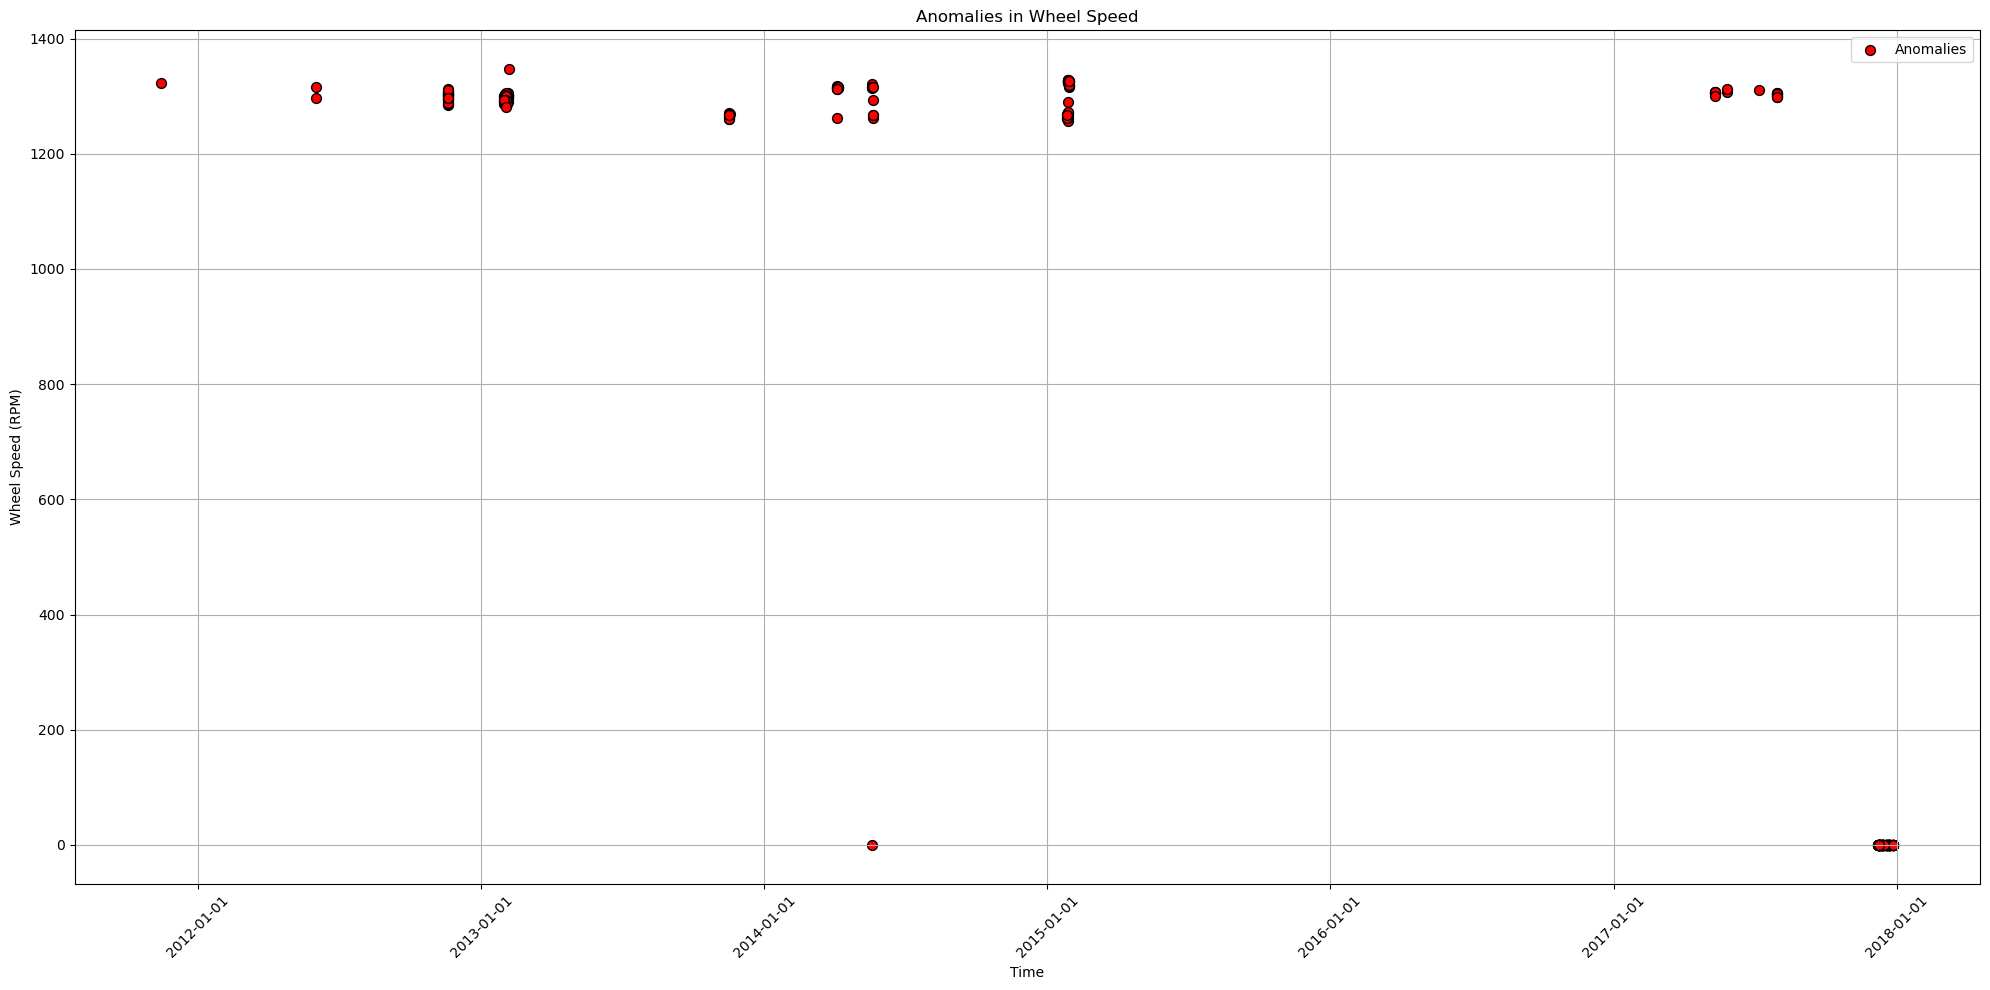

In [13]:
# plotting anomalies
plt.figure(figsize=(20, 10))

# coonvert 'Time' from numpy.datetime64 to datetime for plotting
anomalies_df['Time'] = pd.to_datetime(anomalies_df['Time'])

# highlighting anomalies with red scatter plots
anomalies_present = anomalies_df[anomalies_df['Anomaly'] == True]
plt.scatter(anomalies_present['Time'], anomalies_present['Actual'], color='red', label='Anomalies', s=50, edgecolors='black')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Wheel Speed (RPM)')
plt.title('Anomalies in Wheel Speed')
plt.legend()
plt.grid(True)
plt.tight_layout()  

plt.show()


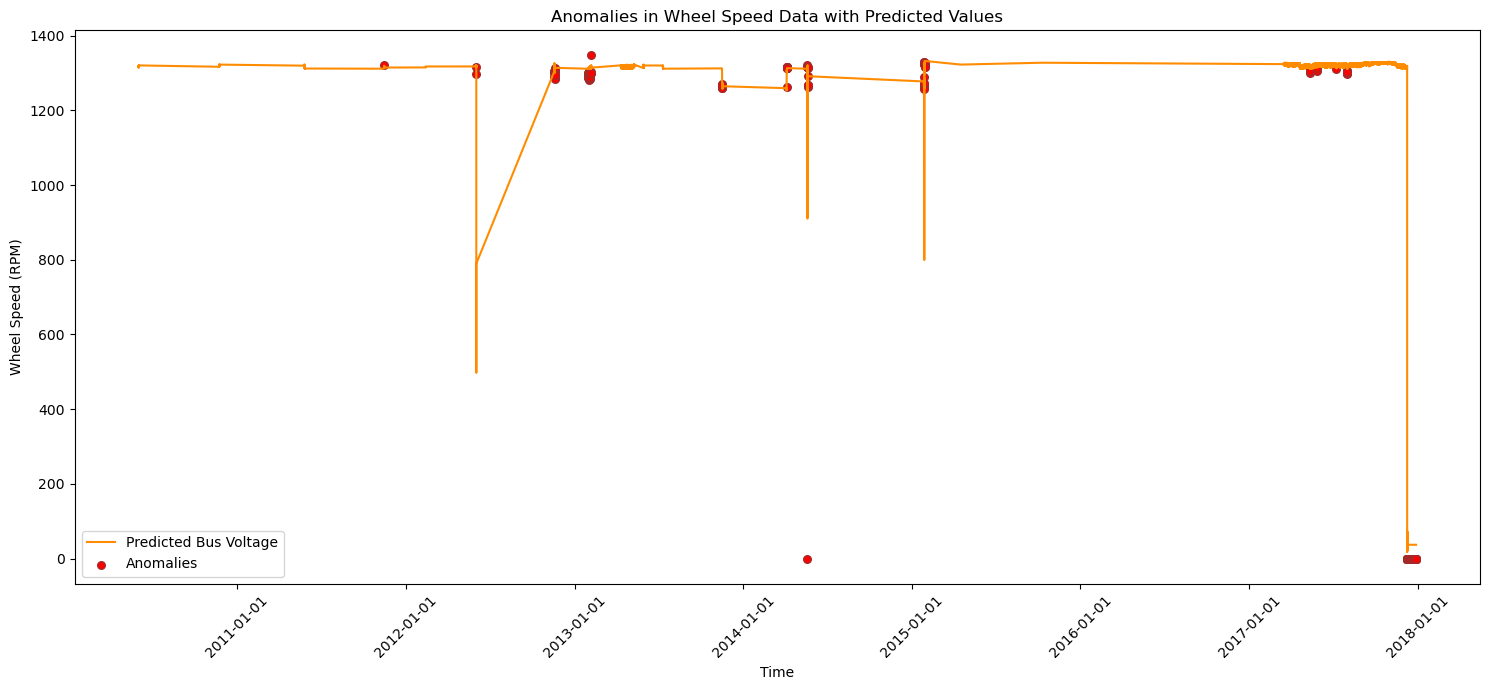

In [14]:
ts_test_datetime = pd.to_datetime(ts_test)

# sort ts_test_datetime, y_test, and y_pred arrays according to the timestamps
sorted_indices = np.argsort(ts_test_datetime)
sorted_test_time_steps = np.array(ts_test_datetime)[sorted_indices]
sorted_y_test_original = y_test_original[sorted_indices]
sorted_y_pred_original = y_test_prediction[sorted_indices]

sorted_anomalies = anomalies[sorted_indices]

plt.figure(figsize=(15, 7))

# # plot the sorted actual values
# plt.plot(sorted_test_time_steps, sorted_y_test_original, label='Actual Bus Voltage', color='dodgerblue')

# plot the sorted predicted values
plt.plot(sorted_test_time_steps, sorted_y_pred_original, label='Predicted Bus Voltage', color='darkorange')

plt.scatter(sorted_test_time_steps[sorted_anomalies], sorted_y_test_original[sorted_anomalies], color='red', label='Anomalies', s=30, edgecolor='brown')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Wheel Speed (RPM)')
plt.title('Anomalies in Wheel Speed Data with Predicted Values')
plt.legend()
plt.tight_layout()
plt.show()


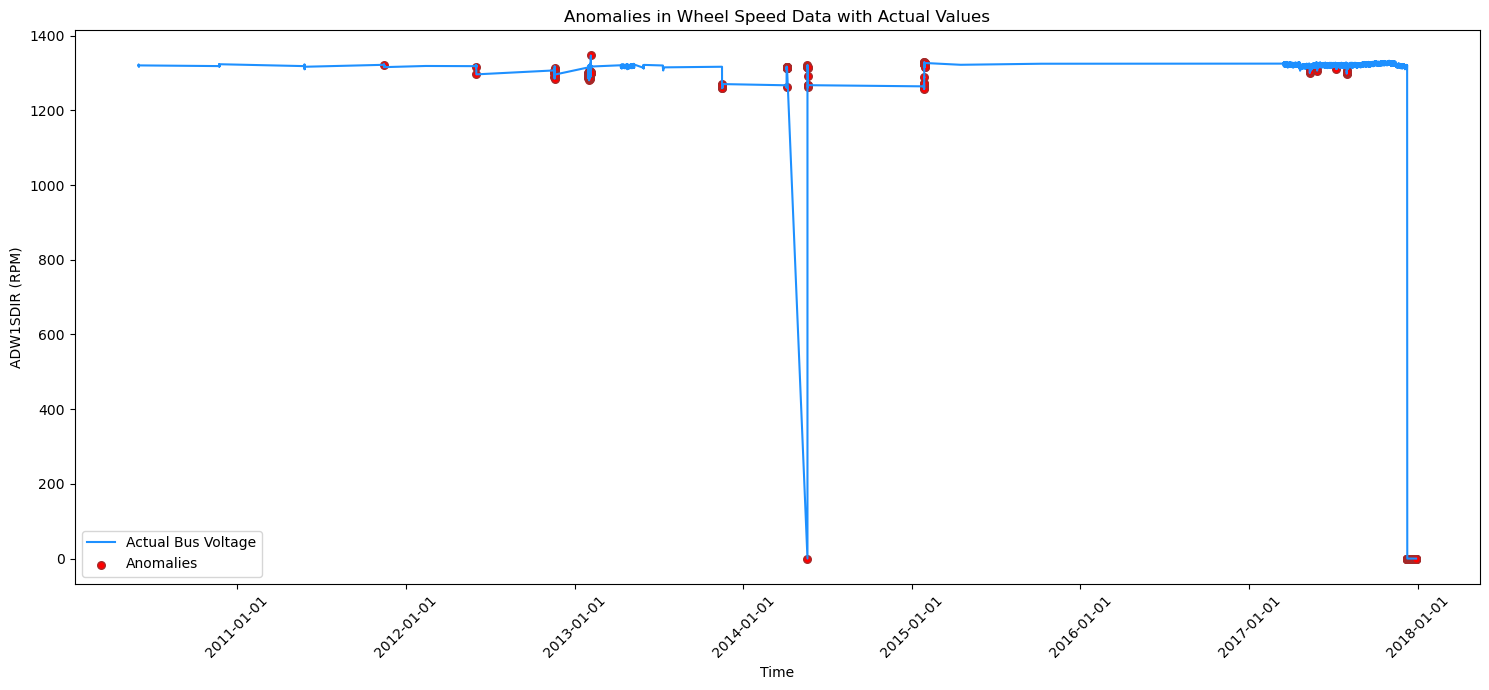

In [15]:
plt.figure(figsize=(15, 7))

# plot the sorted actual values
plt.plot(sorted_test_time_steps, sorted_y_test_original, label='Actual Bus Voltage', color='dodgerblue')

# # plot the sorted predicted values
# plt.plot(sorted_test_time_steps, sorted_y_pred_original, label='Predicted Bus Voltage', color='darkorange')

plt.scatter(sorted_test_time_steps[sorted_anomalies], sorted_y_test_original[sorted_anomalies], color='red', label='Anomalies', s=30, edgecolor='brown')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('ADW1SDIR (RPM)')
plt.title('Anomalies in Wheel Speed Data with Actual Values')
plt.legend()
plt.tight_layout()
plt.show()
